In [1]:
from numpy import sin, cos, arccos, arcsin
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
import ffmpeg
from matplotlib.patches import Circle

In [2]:
# Consider making the animation loading part a package you can just import

In [3]:
# Relevant state parameters will be (theta, dtheta/dt, r, dr/dt)
class SpringPendulum:
    def __init__(self,
                init_state = [120,0,1,0],
                L = 1.0,
                M = 1.0,
                g = 9.81,
                k = 20.0,
                origin = (0,0)):
        
        self.init_state = np.asarray(init_state, dtype = 'float')
        self.params = (L,M,g,k)
        self.origin = origin
        self.elapsed_time = 0
        self.state = [self.init_state[0] * np.pi / 180., self.init_state[1] * np.pi / 180., 
                      self.init_state[2], self.init_state[3]] 

        
    def position(self):
        (L,M,g,k) = self.params
        
        x = np.cumsum([self.origin[0], self.state[2] * sin(self.state[0])])
        y = np.cumsum([self.origin[1], -self.state[2] * cos(self.state[0])])
        
        return (x,y)
    
    def equation(self, state, t):
        (L,M,g,k) = self.params
        theta = state[0]
        omega = state[1]
        r = state[2]
        drdt = state[3]
        dydt = [omega, -1/r*(g * sin(theta) + 2*omega*drdt), drdt, -(k*(r-L))/ M - g*cos(theta) + r*omega**2]
        return dydt
    
    def time_advance(self, dt):
        self.state = integrate.odeint(self.equation,self.state,[0, dt])[1]
        self.elapsed_time += dt
        

In [4]:
pendulum = SpringPendulum()
dt = 1./30 # 30 fps
global l
l = pendulum.params[0]

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


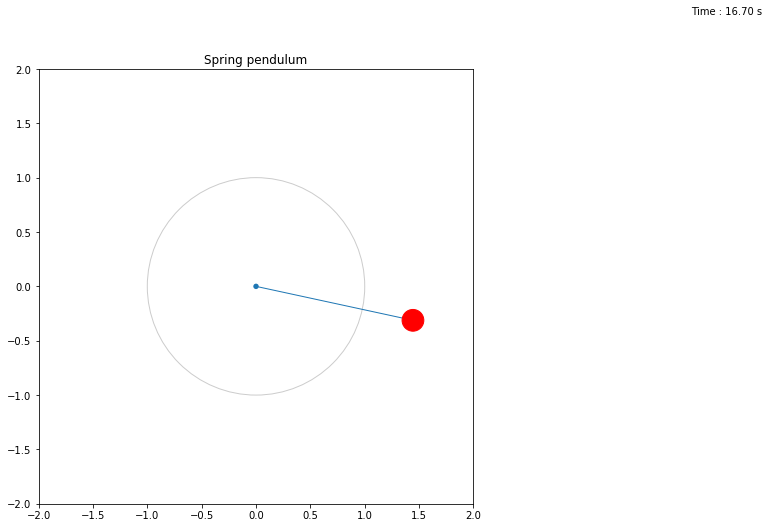

In [5]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-2*l, 2*l), ylim=(-2*l, 2*l))
#ax.grid(False)
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_title('Spring pendulum')


line, = ax.plot([],[], lw = 1)
time_txt = ax.text(4,2.5,'')



def init():
    line.set_data([],[])
    time_txt.set_text('')
    return line, time_txt, 

def animate(i):
    global pendulum, dt
    ax.patches = [] # Redraw patch
    pendulum.time_advance(dt) # Update new position of pendulum 
    line.set_data(*pendulum.position()) # Draw pendulum's position
    pos=pendulum.position()
    x=pos[0][-1]
    y=pos[1][-1]
    time_txt.set_text('Time : %.2f s' % pendulum.elapsed_time)
    c1 = Circle((x,y), 0.1, fc='r', ec='r', zorder=10) 
    c2 = Circle((0,0), 0.025, zorder=10)
    spring_rad = plt.Circle((0,0), l, color='black', fill=False,alpha = 0.2)
    ax.add_patch(c1) # Draw pendulum ball
    ax.add_patch(c2)
    ax.add_patch(spring_rad)
    return line, time_txt
    

# Find optimal interval for animation by basing it on how long the animate function takes to run
from time import time
t0 = time()
animate(0)
t1 = time()
interval = 1000 * dt - (t1 - t0)
    
anim = animation.FuncAnimation(fig,animate,init_func = init, frames = 500, blit = True, interval = interval)

anim.save('spring_pendulum_mine.gif', fps=30, extra_args=['-vcodec', 'libx264'])


plt.show()